In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import Dataset
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, Concatenate, BatchNormalization, Activation, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [99]:
img_width, img_height = 256, 256
input_channels = 3
output_channels = 1
input_shape = (img_width, img_height, input_channels)
output_shape = (img_width, img_height, output_channels)
seed = 13
batch_size = 16

train_dir = "train/image/"
train_mask_dir = "train/label/"
val_dir = "val/image/"
val_mask_dir = "val/label/"
test_dir = "test/image/"
test_mask_dir = "test/label/"

In [4]:
def clean_image_dir(dir_name):
  files = os.listdir(dir_name)
  for f in files:
    file_name = os.path.splitext(f)[0]
    extension = os.path.splitext(f)[1]
    if extension == ".tif":
      img = cv2.imread(dir_name+f)
      cv2.imwrite(dir_name+file_name+".jpg", img)
      os.remove(dir_name+f)

def clean_image_mask_dir(dir_name):
  files = os.listdir(dir_name)
  for f in files:
    file_name = os.path.splitext(f)[0]
    extension = os.path.splitext(f)[1]
    if extension == ".tif":
      img = cv2.imread(dir_name+f)
      img = img[:,:,0]+1
      cv2.imwrite(dir_name+file_name+".png", img)
      os.remove(dir_name+f)

In [5]:
clean_image_dir(train_dir)
clean_image_mask_dir(train_mask_dir)

clean_image_dir(val_dir)
clean_image_mask_dir(val_mask_dir)

clean_image_dir(test_dir)
clean_image_mask_dir(test_mask_dir)

Found 4736 files belonging to 1 classes.
Found 4736 files belonging to 1 classes.
Found 1036 files belonging to 1 classes.
Found 1036 files belonging to 1 classes.
Found 2416 files belonging to 1 classes.
Found 2416 files belonging to 1 classes.


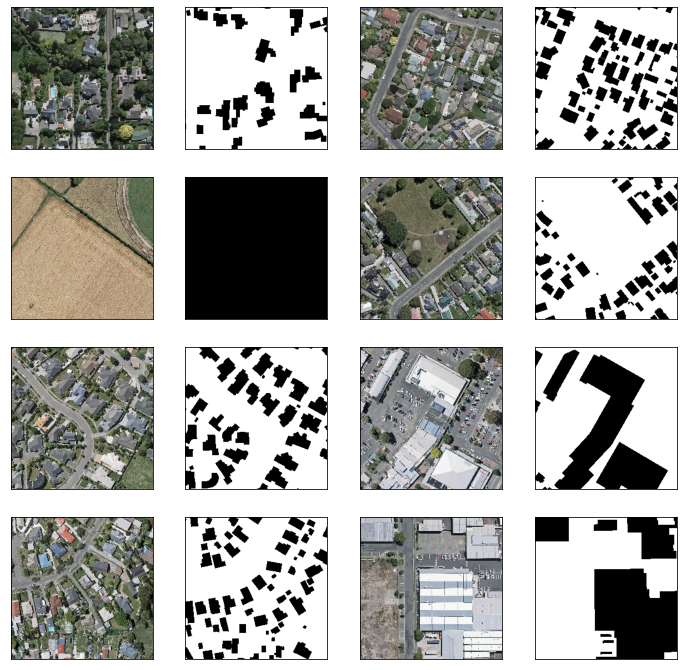

In [7]:
def generate_dataset_from_directory(directory, color_mode="rgb", interpolation="nearest", validation_split=None, subset=None):
  # Generamos el objeto Dataset a partir de un directorio
  ds = image_dataset_from_directory(
      directory,
      labels=None,
      label_mode=None,
      batch_size=batch_size,
      image_size=(img_width, img_height),
      seed=seed,
      interpolation=interpolation,
      color_mode=color_mode,
      validation_split=validation_split,
      subset=subset)
  return ds.prefetch(buffer_size=batch_size)

input_ds_train = generate_dataset_from_directory(train_dir)
mask_ds_train = generate_dataset_from_directory(train_mask_dir, color_mode="grayscale")

input_ds_val = generate_dataset_from_directory(val_dir)
mask_ds_val = generate_dataset_from_directory(val_mask_dir, color_mode="grayscale")

input_ds_test = generate_dataset_from_directory(test_dir)
mask_ds_test = generate_dataset_from_directory(test_mask_dir, color_mode="grayscale")

# En este tipo de problemas tenemos que 'casar' manualmente los datos asignando una máscara a cada una de las imágenes de cada dataset
train_dataset = Dataset.zip((input_ds_train, mask_ds_train))
val_dataset = Dataset.zip((input_ds_val, mask_ds_val))
test_dataset = Dataset.zip((input_ds_test, mask_ds_test))

sample_size = 8
cols = 4
rows = sample_size * 2 // cols
plt.figure(figsize=(cols * 3, rows * 3))

for x_batch, y_batch in train_dataset.take(1):
  for i in range(sample_size):
    plt.subplot(rows, cols, i * 2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_batch[i])
    plt.subplot(rows, cols, i * 2 + 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_batch[i].numpy()[:,:,0], cmap="gray")

In [8]:
def create_model(num_classes, dropout=False):

  # Función para crear cada uno de los bloques de convolución transpuesta, esto es, la operación contraria a la convolución
  # que trata de reconstruir una imagen. En mi caso lo he diseñado haciendo un 'espejo' de los bloques convolucionales.
  def decoder_block(input, skip_connection, num_filters, dropout=0):
      x = Conv2DTranspose(num_filters, 2, strides=2, padding="same", dtype="float32")(input)
      x = Concatenate()([x, skip_connection])

      x = Conv2D(num_filters, 3, padding="same", dtype="float32")(x)
      x = BatchNormalization(dtype="float32")(x)
      x = Activation("relu")(x)

      x = Conv2D(num_filters, 3, padding="same", dtype="float32")(x)
      x = BatchNormalization(dtype="float32")(x)
      x = Activation("relu")(x)

      if dropout:
        x = Dropout(dropout)(x)

      return x

  # Capa de entrada
  inputs = Input(input_shape)

  # Transfer Learning con Modelo ResNet entrenado sobre ImageNet
  residual = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
  
  # Descongelamos las cuatro últimas capas del modelo preentrenado para modificar sus pesos con nuestros datos,
  # de esta forma lo adaptamos mínimamente a nuestro problema
  residual.trainable = False
  residual.layers[-4].trainable = True

  # Outputs del encoder para conexiones residuales
  s1 = residual.get_layer(index=0).output
  s2 = residual.get_layer("conv1_relu").output
  s3 = residual.get_layer("conv2_block3_out").output
  s4 = residual.get_layer("conv3_block4_out").output

  # Puente
  b1 = residual.get_layer("conv4_block6_out").output

  # Decoder
  d1 = decoder_block(b1, s4, 512, 0.4 if dropout else None)
  d2 = decoder_block(d1, s3, 256, 0.3 if dropout else None)
  d3 = decoder_block(d2, s2, 128, 0.3 if dropout else None)
  d4 = decoder_block(d3, s1, 64, 0.2 if dropout else None)

  # Salida de la red
  outputs = Conv2D(num_classes, 3, padding="same", activation="softmax", dtype="float32")(d4)

  model = Model(inputs, outputs)
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy") 

  return model

In [9]:
model = create_model(2, dropout=True)

callbacks = [
             ModelCheckpoint(
                 'checkpoint/resnet-{val_loss:03f}-({epoch:02d}).h5',
                 monitor='val_loss',
                 save_best_only=True),
             EarlyStopping(monitor="val_loss", patience=10)
]

history = model.fit(
    train_dataset,
    epochs=100,
    batch_size=batch_size,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/100
296/296 [==============================] - ETA: 0s - loss: 0.1437

C:\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


296/296 [==============================] - 88s 267ms/step - loss: 0.1437 - val_loss: 0.0723
Epoch 2/100
296/296 [==============================] - 77s 261ms/step - loss: 0.1022 - val_loss: 0.0683
Epoch 3/100
296/296 [==============================] - 69s 233ms/step - loss: 0.0884 - val_loss: 0.0567
Epoch 4/100
296/296 [==============================] - 70s 235ms/step - loss: 0.0830 - val_loss: 0.0563s: 0
Epoch 5/100
296/296 [==============================] - 68s 230ms/step - loss: 0.0747 - val_loss: 0.0537
Epoch 6/100
296/296 [==============================] - 67s 226ms/step - loss: 0.0692 - val_loss: 0.0572
Epoch 7/100
296/296 [==============================] - 67s 227ms/step - loss: 0.0655 - val_loss: 0.0528
Epoch 8/100
296/296 [==============================] - 67s 227ms/step - loss: 0.0613 - val_loss: 0.0522
Epoch 9/100
296/296 [==============================] - 67s 226ms/step - loss: 0.0596 - val_loss: 0.0624
Epoch 10/100
296/296 [==============================] - 67s 226ms/step -

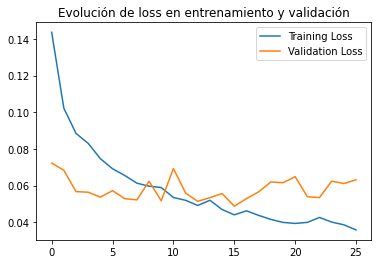

In [10]:
def show_training_graph(data):
  loss = data.history['loss']
  val_loss = data.history['val_loss']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Evolución de loss en entrenamiento y validación')
  plt.legend(loc='upper right')

  plt.show()

show_training_graph(history)

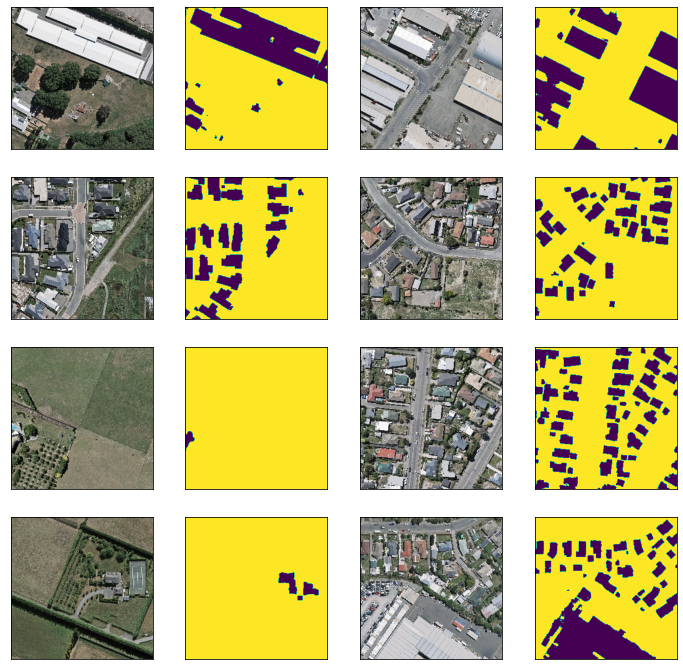

In [11]:
sample_size = 8
cols = 4
rows = sample_size * 2 // cols

plt.figure(figsize=(cols * 3, rows * 3))

for x_batch, y_batch in test_dataset.take(1):
  for i in range(sample_size):
    plt.subplot(rows, cols, i * 2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_batch[i])
    plt.subplot(rows, cols, i * 2 + 2)
    plt.xticks([])
    plt.yticks([])
    prediction = model.predict(np.expand_dims(x_batch[i], 0))[0]
    prediction = np.argmax(prediction, axis=-1)
    plt.imshow(prediction)

In [21]:
model.save("modelo_tfg_2.h5")

In [3]:
model = load_model("modelo_tfg_2.h5")

In [6]:
#img = cv2.imread(train_dir+"20.jpg")
img = cv2.imread("test_final.png")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = cv2.resize(img, (256,256))

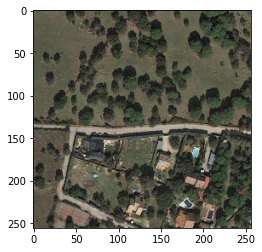

In [7]:
plt.imshow(img)

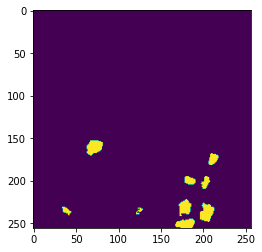

In [8]:
prediction = model.predict(np.expand_dims(img, 0))[0]
prediction = np.argmax(prediction, axis=-1)
prediction[prediction == 0] = 255
prediction[prediction == 1] = 0
plt.imshow(prediction)

In [9]:
prediction = np.uint8(prediction)
prediction = cv2.blur(prediction, (3,3))
contours, hierarchy = cv2.findContours(prediction,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

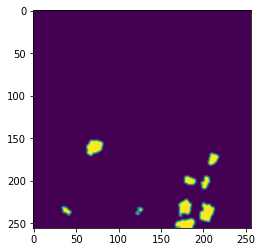

In [10]:
plt.imshow(prediction)

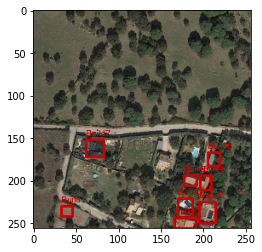

In [11]:
idx = 0
color = [tuple(np.random.choice(range(256), size=3)) for x in range(len(contours))]
for cnt in contours:
  x,y,w,h = cv2.boundingRect(cnt)
  if w > 10 and h > 10:
    roi=img[y:y+h,x:x+w]
    # cv2.rectangle(img,(x,y),(x+w,y+h),(int(color[idx][0]), int(color[idx][1]),int(color[idx][2])),2)
    cv2.rectangle(img,(x,y),(x+w,y+h),(200, 0, 0),2)
    # cv2.putText(img, "Build"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (int(color[idx][0]), int(color[idx][1]),int(color[idx][2])), 1)
    cv2.putText(img, "Build"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(200, 0, 0), 1)
    idx += 1
plt.imshow(img)

In [10]:
cap = cv2.VideoCapture('test_warcelona.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    frame = cv2.resize(frame, (256,256))
    prediction = model.predict(np.expand_dims(frame, 0))[0]
    prediction = np.argmax(prediction, axis=-1)
    prediction[prediction == 0] = 255
    prediction[prediction == 1] = 0
    prediction = np.uint8(prediction)
    prediction = cv2.blur(prediction, (3,3))
    contours, hierarchy = cv2.findContours(prediction,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    idx = 0
    color = [tuple(np.random.choice(range(256), size=3)) for x in range(len(contours))]
    for cnt in contours:
      x,y,w,h = cv2.boundingRect(cnt)
      if w > 10 and h > 10:
        roi=frame[y:y+h,x:x+w]
        # cv2.rectangle(img,(x,y),(x+w,y+h),(int(color[idx][0]), int(color[idx][1]),int(color[idx][2])),2)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 0, 200),2)
        # cv2.putText(img, "Build"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (int(color[idx][0]), int(color[idx][1]),int(color[idx][2])), 1)
        cv2.putText(frame, "Building"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(200, 0, 0), 1)
        idx += 1
    frame = cv2.resize(frame, (1080,720))
    prediction = cv2.cvtColor(prediction,cv2.COLOR_GRAY2RGB)
    prediction = cv2.resize(prediction, (1080,720))
    numpy_horizontal_concat = np.concatenate((frame, prediction), axis=1)

    cv2.imshow('frame', numpy_horizontal_concat)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...
